# DESIGNTK 530 - I10 Applying Unsupervised Methods to Data

## Problem 2.1
*Load the dataset in .csv format in your local VSCode environment. Create at least two new exploratory data visualizations.*

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import json

In [3]:
rei_catalog_data = pd.read_csv("data/cleaned_rei_data.csv")
print(rei_catalog_data.info())
print(rei_catalog_data.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 229 entries, 0 to 228
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   item_name         229 non-null    object 
 1   item_brand        229 non-null    object 
 2   item_price        229 non-null    float64
 3   item_description  229 non-null    object 
 4   item_id           229 non-null    object 
 5   item_materials    229 non-null    object 
dtypes: float64(1), object(5)
memory usage: 10.9+ KB
None
       item_price
count  229.000000
mean    78.781790
std     77.648212
min      5.950000
25%     25.000000
50%     49.950000
75%     99.950000
max    500.000000


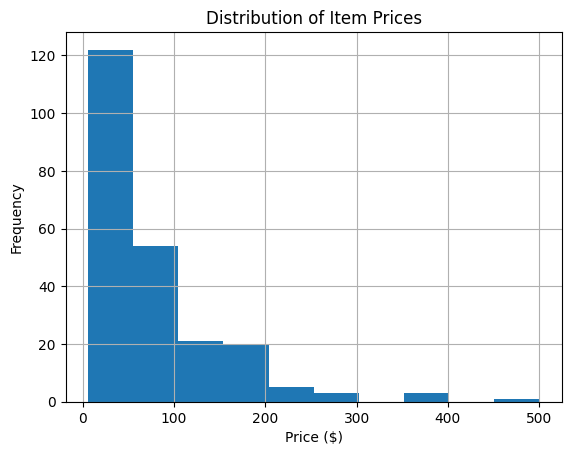

In [7]:
plt.figure()
rei_catalog_data["item_price"].hist()
plt.title("Distribution of Item Prices")
plt.xlabel("Price ($)")
plt.ylabel("Frequency")
plt.show()

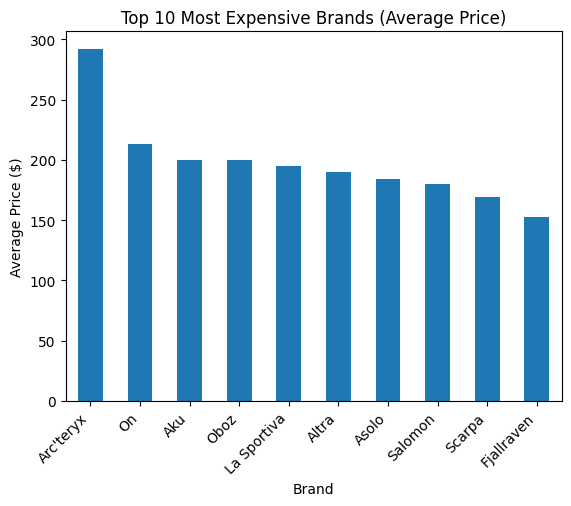

In [9]:
brand_avg = (
    rei_catalog_data.groupby("item_brand")["item_price"]
    .mean()
    .sort_values(ascending=False)
    .head(10)
)
plt.figure()
brand_avg.plot(kind="bar")
plt.title("Top 10 Most Expensive Brands (Average Price)")
plt.xlabel("Brand")
plt.ylabel("Average Price ($)")
plt.xticks(rotation=45, ha="right")
plt.show()

In [4]:
brand_ecoscores = pd.read_csv("data/brand_eco_scores.csv")
print(brand_ecoscores.info())
print(brand_ecoscores.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48 entries, 0 to 47
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   item_brand       48 non-null     object 
 1   brand_eco_score  48 non-null     float64
dtypes: float64(1), object(1)
memory usage: 896.0+ bytes
None
       brand_eco_score
count        48.000000
mean          0.318867
std           0.121411
min           0.100000
25%           0.200000
50%           0.296481
75%           0.433333
max           0.650000


In [11]:
brand_ecoscores.head(5)

,item_brand,brand_eco_score
0,Arms of Andes,0.650000
1,Royal Robbins,0.512500
2,Fjallraven,0.500000
3,Smartwool,0.466979
4,On,0.461111


## Problem 2.2
*Select one of the Unsupervised methods covered in class to apply to your dataset:  

- K-Means Clustering
- Principal Component Analysis 

Explain: What would you hope to understand about the data from applying this method? How would the result inform or enhance the experience/application you identified in your project proposal? *

> K-Means Clustering - by clustering I can understand if the REI products naturally fall into groups like high price = high eco_score vice versa (low price). This means that I can see whether sustainability (ecoscore) correlates with pricing and branding. This will further help enhance the user experience in that they will have accurated correlated data regarding pricing and eco.

## Problem 2.3
*Apply the selected method to your dataset using python and scikit-learn. Please clearly note features selected.  
Visualize the results, and answer the following questions:  
- What patterns, groupings, or relationships does the method reveal about your data? 
- Evaluate the outputs in line with your expectations.  
- How does this support the experience you aim to create?*

In [13]:
with open("data/materials_updated.json", "r") as f:
    materials_json = json.load(f)
# {material_name : eco_score}
material_scores = {}

for category, contents in materials_json.items():
    for key, attributes in contents.items():
        if isinstance(attributes, dict) and "eco_score" in attributes:
            clean_name = attributes["name"].lower()
            material_scores[clean_name] = attributes["eco_score"]


In [15]:
def compute_material_ecoscore(materials_text):
    materials_text = str(materials_text).lower()
    
    scores = [
        score for material, score in material_scores.items()
        if material in materials_text
    ]
    
    return sum(scores) / len(scores) if scores else None

rei_catalog_data["material_eco_score"] = rei_catalog_data["item_materials"].apply(compute_material_ecoscore)


In [16]:
rei = rei_catalog_data.merge(brand_ecoscores, on="item_brand", how="left")
rei.head(5)

,item_name,item_brand,item_price,item_description,item_id,item_materials,material_eco_score,brand_eco_score
0,Darn Tough Bear Town Micro Crew Socks - Women's,Darn Tough,25.00,Lightly cushioned hiking socks with all the an...,#159260,54% nylon/43% merino wool/3% lycra spandex,0.433333,0.433333
1,Royal Robbins Westlands Relaxed Pullover - W...,Royal Robbins,82.73,Spend the cooler months in this cozy Royal Rob...,#255834,60% merino wool/40% recycled polyester,0.512500,0.512500
2,The North Face L/S Lightrange Shirt - Women's,The North Face,46.83,"Designed for hiking, the women's The North Fac...",#243580,main body: 100 g/m2 82% recycled polyester/18%...,0.450000,0.370833
3,Woolrich Merino Wool Hiking Crew Socks - Men's,Woolrich,17.73,"Ideal for year-round hiking, these Woolrich me...",#229499,79% merino wool/20% nylon/1% lycra spandex,0.433333,0.433333
4,REI Co-op Sahara Stretch Convertible Pants -...,REI Co-op,49.83,Inspired by our iconic hiking pants—but design...,#242644,88% nylon/12% spandex (bluesign approved),0.150000,0.292963


In [21]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

features = rei[["item_price", "material_eco_score", "brand_eco_score"]].dropna()
scaler = StandardScaler()
scaled = scaler.fit_transform(features)

kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(scaled)

rei.loc[features.index, "cluster"] = clusters

/Users/pinkhathacker/VS Code/dti-projects/DTech530/DTI530_FinalProject/.venv/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


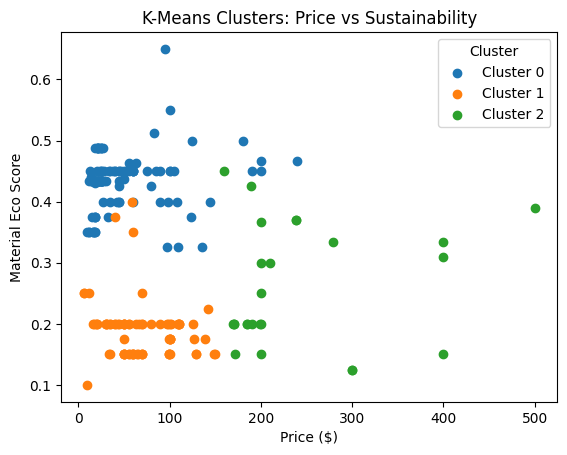

In [23]:
for cluster_id in set(clusters):
    mask = clusters == cluster_id
    plt.scatter(
        features["item_price"][mask],
        features["material_eco_score"][mask],
        label=f"Cluster {cluster_id}"
    )

plt.xlabel("Price ($)")
plt.ylabel("Material Eco Score")
plt.title("K-Means Clusters: Price vs Sustainability")
plt.legend(title="Cluster")
plt.show()

## Problem 2.4 Stretch
Apply one or more other unsupervised methods to your dataset.  

Compare and contrast the outcomes.  

Visualize and interpret the differences between methods.

In [26]:
from sklearn.decomposition import PCA
scaler = StandardScaler()
scaled_data_pca = scaler.fit_transform(features)

# Perform PCA
pca = PCA(n_components=2)  # Reduce to 2 components for visualization
pca_data = pca.fit_transform(scaled_data_pca)

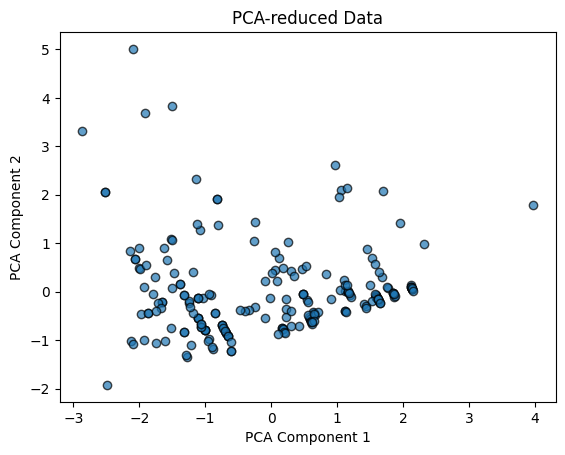

In [27]:
# Visualize PCA-reduced data
plt.scatter(pca_data[:, 0], pca_data[:, 1], alpha=0.7, edgecolor='k')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('PCA-reduced Data')
plt.show()